## 1. Setup and Data Preparation

In [10]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dieboldmariano import dm_test
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FuncFormatter

# Import Machine Learning & Forecasting Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pmdarima as pm
from prophet import Prophet
import lightgbm as lgb

# Set plot style for consistency
sns.set_style("whitegrid")

# Load the final model-ready dataset, parsing the 'date' column as the index
df = pd.read_csv("C:\\Users\\Ashish Siwach\\OneDrive - University of Exeter\\Dissertation_Cld\\Datasets\\enhanced_imputed_dataset.csv", parse_dates=['date'], index_col='date')

## 2. Feature Engineering for Models

In [11]:
# Create a lagged feature for Google Trends Index based on EDA (cross-correlation analysis)
df['GT_Index_lag_2'] = df['GT_Index'].shift(2)
print("Created GT_Index_lag_2 based on CCF analysis.")

# Create month feature for seasonality
df['month'] = df.index.month

# Create a simple time trend feature
df['time_trend'] = range(1, len(df) + 1)

# Create a categorical policy regime feature based on the grant amount
def assign_policy_regime(grant_amount):
    if grant_amount >= 5000:
        return 'High_Grant'
    elif grant_amount >= 3000:
        return 'Medium_Grant'
    elif grant_amount > 0:
        return 'Low_Grant'
    else: # grant_amount == 0
        return 'No_Grant'

df['policy_regime'] = df['PiCG_Amount_GBP'].apply(assign_policy_regime)
print("Successfully created 'policy_regime' column.")

# For Prophet, the date needs to be a column named 'ds', not an index
df_prophet = df.reset_index()

print("Libraries and data loaded successfully.")

Created GT_Index_lag_2 based on CCF analysis.
Successfully created 'policy_regime' column.
Libraries and data loaded successfully.


## 3. Train/Test Split

In [12]:
# Define the target variable for clarity
TARGET = 'BEV_Registrations'

# Define the split point for a 24-month test period
split_date = '2022-06-30'

# Create training and testing sets
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

# Create a separate split for the Prophet model's required format
train_prophet = df_prophet.loc[df_prophet['date'] <= split_date].copy()
test_prophet = df_prophet.loc[df_prophet['date'] > split_date].copy()

print(f"--- Data Split ---")
print(f"Training data runs from {train.index.min().date()} to {train.index.max().date()} ({len(train)} months)")
print(f"Testing data runs from {test.index.min().date()} to {test.index.max().date()} ({len(test)} months)")

--- Data Split ---
Training data runs from 2011-01-31 to 2022-06-30 (138 months)
Testing data runs from 2022-07-31 to 2024-06-30 (24 months)


## 4. Model Training

### 4.1 Baseline Model: Linear Regression with Seasonality

In [13]:
print("\n--- Training Baseline Model: Linear Regression ---")
baseline_features = ['time_trend']
seasonal_dummies = pd.get_dummies(train['month'], prefix='month', drop_first=True)
train_baseline = train.join(seasonal_dummies)

# Add the same dummy columns to the test set for prediction later
seasonal_dummies_test = pd.get_dummies(test['month'], prefix='month', drop_first=True)
test_baseline = test.join(seasonal_dummies_test)
train_labels, test_labels = train_baseline.align(test_baseline, join='right', axis=1, fill_value=0)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(train_labels[baseline_features + list(seasonal_dummies.columns)], train_labels[TARGET])
print("Baseline model trained successfully.")


--- Training Baseline Model: Linear Regression ---
Baseline model trained successfully.


### 4.2 Advanced Model 1: SARIMAX

In [14]:
print("\n--- Training Advanced Model 1: SARIMAX ---")
exog_vars_sarimax = ['RHDI_per_head', 'Charging_Infrastructure_lag_1', 'GT_Index_lag_2']

# Use auto_arima to find the best model parameters
sarimax_model = pm.auto_arima(train[TARGET],
                              exogenous=train[exog_vars_sarimax],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3,
                              m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1,
                              trace=False, # Set to True to see search steps
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(f"SARIMAX model trained. Best order: {sarimax_model.order}, Seasonal order: {sarimax_model.seasonal_order}")


--- Training Advanced Model 1: SARIMAX ---
SARIMAX model trained. Best order: (2, 1, 1), Seasonal order: (0, 1, 1, 12)


### 4.3 Advanced Model 2: Facebook Prophet

In [15]:
print("\n--- Training Advanced Model 2: Prophet ---")
exog_vars_prophet = ['RHDI_per_head', 'Charging_Infrastructure_lag_1', 'GT_Index_lag_2']
train_prophet_df = train[[TARGET] + exog_vars_prophet].reset_index().rename(columns={'date': 'ds', TARGET: 'y'})

# Drop any rows with NaN values from lagged features
train_prophet_df_cleaned = train_prophet_df.dropna()
print(f"Prophet training data cleaned: {len(train_prophet_df_cleaned)} rows remaining.")

# Initialize the model and add regressors
prophet_model = Prophet(growth='linear')
for var in exog_vars_prophet:
    prophet_model.add_regressor(var)

# Train the model
prophet_model.fit(train_prophet_df_cleaned)
print("Prophet model trained successfully.")


--- Training Advanced Model 2: Prophet ---
Prophet training data cleaned: 136 rows remaining.


08:38:18 - cmdstanpy - INFO - Chain [1] start processing
08:38:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully.


### 4.4 Advanced Model 3: LightGBM

In [16]:
print("\n--- Training Advanced Model 3: LightGBM ---")
# Define features as all columns except the target
all_features = [col for col in train.columns if col != TARGET]
categorical_features = ['month', 'policy_regime']

# Create dummy variables and align train/test sets
train_processed = pd.get_dummies(train[all_features + [TARGET]], columns=categorical_features, drop_first=True)
test_processed = pd.get_dummies(test[all_features + [TARGET]], columns=categorical_features, drop_first=True)
train_final, test_final_aligned = train_processed.align(test_processed, join='inner', axis=1)

final_lgb_features = [col for col in train_final.columns if col != TARGET]

# Clean the training data by handling NaNs
train_lgb = train_final.bfill().dropna()
X_train_lgb = train_lgb[final_lgb_features]
y_train_lgb = train_lgb[TARGET]

print(f"LightGBM training data cleaned: {X_train_lgb.shape[0]} rows and {X_train_lgb.shape[1]} features.")

# Train the model
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
lgb_model.fit(X_train_lgb, y_train_lgb)
print("LightGBM model trained successfully.")


--- Training Advanced Model 3: LightGBM ---
LightGBM training data cleaned: 138 rows and 65 features.
LightGBM model trained successfully.


## 5. Model Evaluation

### 5.1 Generating Forecasts on Test Set

In [17]:
print("\n--- Generating all model forecasts on the test set ---")

# Baseline forecast
baseline_preds = lr_model.predict(test_labels[baseline_features + list(seasonal_dummies.columns)])
test['baseline_preds'] = baseline_preds

# SARIMAX forecast
sarimax_preds = sarimax_model.predict(n_periods=len(test), exogenous=test[exog_vars_sarimax])
test['sarimax_preds'] = sarimax_preds

# Prophet forecast
future_df_prophet = test[exog_vars_prophet].reset_index().rename(columns={'date': 'ds'})
prophet_forecast = prophet_model.predict(future_df_prophet)
test['prophet_preds'] = prophet_forecast['yhat'].values

# LightGBM iterative forecast
history = train_final.copy()
lgb_preds = []
for i in range(len(test_final_aligned)):
    current_step_df = pd.concat([history, test_final_aligned.iloc[[i]]])
    for lag in [1, 12]:
        current_step_df[f'{TARGET}_lag_{lag}'] = current_step_df[TARGET].shift(lag)
    current_features = current_step_df[final_lgb_features].tail(1)
    pred = lgb_model.predict(current_features)[0]
    lgb_preds.append(pred)
    history = pd.concat([history, test_final_aligned.iloc[[i]]])
test['lgb_preds'] = lgb_preds

print("All forecasts generated.")


--- Generating all model forecasts on the test set ---
All forecasts generated.


### 5.2 Comparing Performance Metrics

In [18]:
print("\n--- Comparing Model Performance ---")
models_to_eval = ['baseline_preds', 'sarimax_preds', 'prophet_preds', 'lgb_preds']
performance = {}

for model_name in models_to_eval:
    preds = test[model_name]
    wape = np.sum(np.abs(test[TARGET] - preds)) / np.sum(np.abs(test[TARGET]))
    mape = mean_absolute_percentage_error(test[TARGET], preds)
    rmse = np.sqrt(mean_squared_error(test[TARGET], preds))
    mae = mean_absolute_error(test[TARGET], preds)
    performance[model_name.replace('_preds','')] = {'WAPE': wape, 'MAPE': mape, 'RMSE': rmse, 'MAE': mae}

performance_df = pd.DataFrame(performance).T
performance_df['WAPE'] = performance_df['WAPE'].apply('{:.2%}'.format)
performance_df['MAPE'] = performance_df['MAPE'].apply('{:.2%}'.format)
performance_df['RMSE'] = performance_df['RMSE'].apply('{:,.0f}'.format)
performance_df['MAE'] = performance_df['MAE'].apply('{:,.0f}'.format)

print("\nModel Performance Summary:")
print(performance_df)


--- Comparing Model Performance ---

Model Performance Summary:
            WAPE    MAPE    RMSE     MAE
baseline  47.32%  44.04%  23,197  20,382
sarimax   15.05%  13.95%   8,216   6,484
prophet   30.03%  32.77%  15,240  12,935
lgb       34.33%  31.81%  17,944  14,788


### 5.3 Visualizing Forecasts


--- Visualizing Forecast Comparison ---


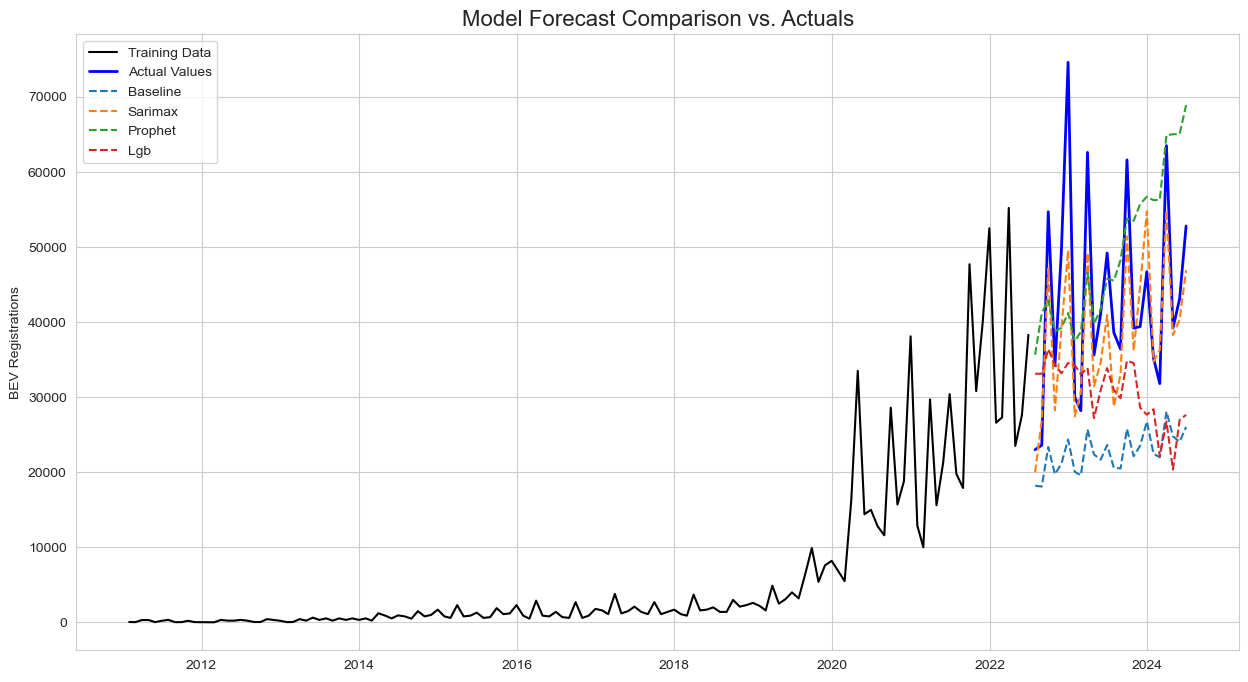

In [19]:
print("\n--- Visualizing Forecast Comparison ---")
plt.figure(figsize=(15, 8))
plt.plot(train.index, train[TARGET], label='Training Data', color='black')
plt.plot(test.index, test[TARGET], label='Actual Values', color='blue', linewidth=2)
for model_name in models_to_eval:
    plt.plot(test.index, test[model_name], label=model_name.replace('_preds','').capitalize(), linestyle='--')
plt.title('Model Forecast Comparison vs. Actuals', fontsize=16)
plt.ylabel('BEV Registrations')
plt.legend()
plt.show()

### 5.4 Statistical Significance Test (Diebold-Mariano)

In [20]:
print("\n--- Diebold-Mariano Statistical Test ---")
# Assuming SARIMAX is the best model based on the performance table
best_model_preds = test['sarimax_preds']
competitors = ['baseline_preds', 'prophet_preds', 'lgb_preds']
actuals = test[TARGET]

for competitor_name in competitors:
    competitor_preds = test[competitor_name]
    dm_result = dm_test(actuals, best_model_preds, competitor_preds, h=1)
    
    print(f"\nComparing SARIMAX vs. {competitor_name.replace('_preds','').capitalize()}:")
    print(f"DM Statistic: {dm_result[0]:.2f}, p-value: {dm_result[1]:.3f}")
    if dm_result[1] < 0.05:
        print("Result: The difference is statistically significant (p < 0.05).")
    else:
        print("Result: The difference is not statistically significant (p >= 0.05).")


--- Diebold-Mariano Statistical Test ---

Comparing SARIMAX vs. Baseline:
DM Statistic: -4.78, p-value: 0.000
Result: The difference is statistically significant (p < 0.05).

Comparing SARIMAX vs. Prophet:
DM Statistic: -3.69, p-value: 0.001
Result: The difference is statistically significant (p < 0.05).

Comparing SARIMAX vs. Lgb:
DM Statistic: -3.69, p-value: 0.001
Result: The difference is statistically significant (p < 0.05).


## 5.5 SARIMAX Model Diagnostics


--- SARIMAX Model Residual Diagnostics ---


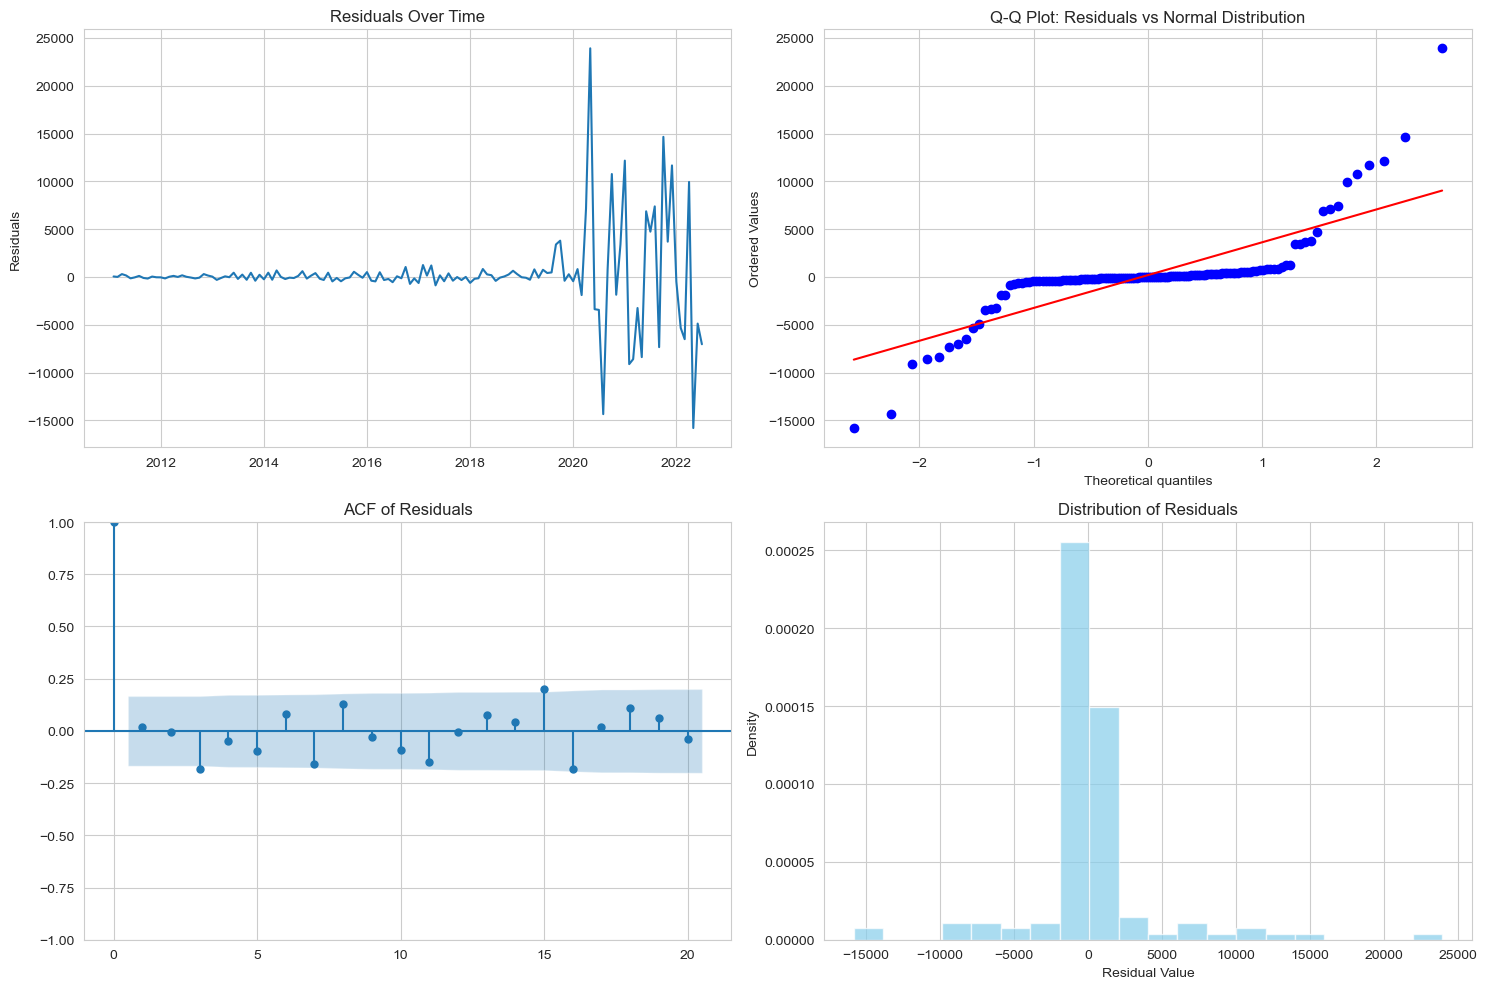


Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
1    0.037390   0.846672
2    0.044741   0.977878
3    4.934779   0.176636
4    5.271128   0.260592
5    6.604385   0.251764
6    7.564461   0.271779
7   11.192722   0.130431
8   13.672632   0.090707
9   13.807282   0.129348
10  15.121066   0.127710

Shapiro-Wilk Test for Normality:
Statistic: 0.6622, p-value: 0.0000

Residual Analysis: No significant autocorrelation detected (good)
Residuals show some deviation from normality


In [21]:
# %% [markdown]
# ### 5.5 SARIMAX Model Diagnostics

# %%
print("\n--- SARIMAX Model Residual Diagnostics ---")
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import seaborn as sns

# Get residuals from the SARIMAX model
residuals = sarimax_model.resid()

# Create a figure with multiple subplots for diagnostics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals plot
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals Over Time')
axes[0,0].set_ylabel('Residuals')
axes[0,0].grid(True)

# 2. Q-Q plot for normality
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot: Residuals vs Normal Distribution')

# 3. ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=axes[1,0], lags=20, title='ACF of Residuals')

# 4. Histogram of residuals
axes[1,1].hist(residuals, bins=20, density=True, alpha=0.7, color='skyblue')
axes[1,1].set_title('Distribution of Residuals')
axes[1,1].set_xlabel('Residual Value')
axes[1,1].set_ylabel('Density')
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('sarimax_residual_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

# Ljung-Box test for autocorrelation in residuals
ljung_box_result = acorr_ljungbox(residuals, lags=10, return_df=True)
print("\nLjung-Box Test for Residual Autocorrelation:")
print(ljung_box_result)

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)
print(f"\nShapiro-Wilk Test for Normality:")
print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_pvalue:.4f}")

if ljung_box_result['lb_pvalue'].iloc[-1] > 0.05:
    print("\nResidual Analysis: No significant autocorrelation detected (good)")
else:
    print("\nResidual Analysis: Some autocorrelation remains in residuals")
    
if shapiro_pvalue > 0.05:
    print("Residuals appear normally distributed (good)")
else:
    print("Residuals show some deviation from normality")

## 6. STRATEGIC FORECASTING & SCENARIO ANALYSIS

=============================================================================

In this part, we use our findings to conduct the final long-term analysis.

We will use the champion SARIMAX model for short-term forecast of BEV Sales

and a Logistic Growth model(S curve) for long-term strategic scenarios.

=============================================================================

### 6.1 SARIMAX Scenario Modelling for short term tactical decisions

#### SARIMAX training on full data

In [ ]:
import pandas as pd
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

# (Assuming 'df' is your loaded and prepared DataFrame)

# --- 1. Define Variables ---
TARGET = 'BEV_Registrations'
exog_vars = ['RHDI_per_head', 'Charging_Infrastructure_lag_1', 'GT_Index_lag_2']

# Use .bfill() to handle any initial NaNs in exogenous variables
y_train_full = df[TARGET]
X_train_full = df[exog_vars].bfill()

# --- 2. Run auto_arima to find the best parameters ---
print("--- Searching for optimal SARIMAX parameters using auto_arima... ---")
# Use auto_arima to find the best model parameters
auto_arima_search = pm.auto_arima(X_train_full,
                              exogenous=train[exog_vars_sarimax],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3,
                              m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1,
                              trace=False, # Set to True to see search steps
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

# --- 3. Extract and Store the Optimal Parameters ---
best_order = auto_arima_search.order
best_seasonal_order = auto_arima_search.seasonal_order

print("\n--- Search Complete ---")
print(f"Optimal Order (p,d,q): {best_order}")
print(f"Optimal Seasonal Order (P,D,Q,m): {best_seasonal_order}")

print("\nOptimal parameters have been identified.")

--- Searching for optimal SARIMAX parameters using auto_arima... ---

--- Search Complete ---
Optimal Order (p,d,q): (1, 0, 1)
Optimal Seasonal Order (P,D,Q,m): (1, 0, 0, 12)

Optimal parameters have been identified.


#### Statsmodel Forecast

In [108]:
import pandas as pd
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# (Assuming 'df' and the training variables 'y_train_full'
# and 'X_train_full' from Step 1 are in memory)

# --- 1. Define the Optimal Parameters Found by auto_arima ---
# These are the parameters you provided from the previous step's output.
best_order = (1, 0, 1)
best_seasonal_order = (1, 0, 0, 12)

print("--- Building final statsmodels SARIMAX model with optimal parameters ---")

# --- 2. Initialize the statsmodels SARIMAX model ---
# We use the parameters found by auto_arima to create a new, clean model.
final_statsmodels_model = sm.tsa.SARIMAX(
    endog=y_train_full,
    exog=X_train_full,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# --- 3. Fit the model to the data ---
# This is the final trained model object we will use for forecasting.
final_statsmodels_results = final_statsmodels_model.fit(disp=False)

# --- 4. Print the model summary to verify ---
# This confirms the model was built correctly with the specified parameters.
print("\n--- Final Model Summary ---")
print(final_statsmodels_results.summary())

print("\nThe final statsmodels SARIMAX model has been trained.")

--- Building final statsmodels SARIMAX model with optimal parameters ---

--- Final Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                   BEV_Registrations   No. Observations:                  162
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1505.470
Date:                             Fri, 22 Aug 2025   AIC                           3024.939
Time:                                     13:50:59   BIC                           3045.967
Sample:                                 01-31-2011   HQIC                          3033.482
                                      - 06-30-2024                                         
Covariance Type:                               opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

#### Scenario Definition and Visualizing the forecasts

--- Defining future scenarios for a 3-year policy-relevant horizon ---
Future exogenous variables created correctly.

--- Generating forecasts for scenarios using statsmodels ---

--- Generating main forecast plot ---
Generated 'sarimax_3_year_forecast_main_corrected.png'


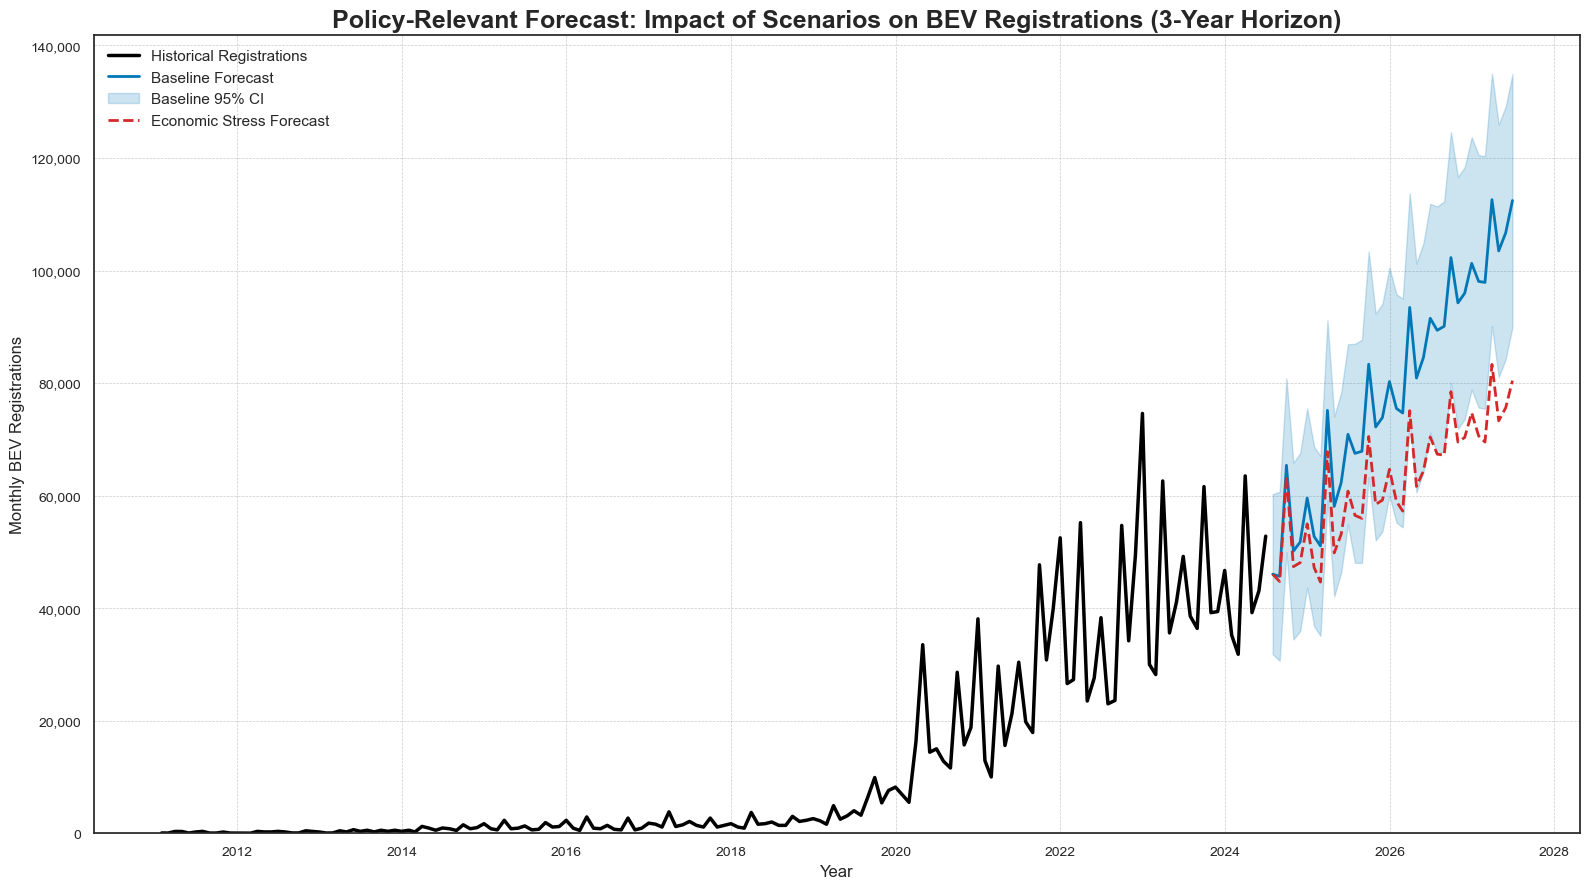


--- Generating impact analysis plot (Forecast Difference) ---
Generated 'sarimax_forecast_difference_corrected.png'


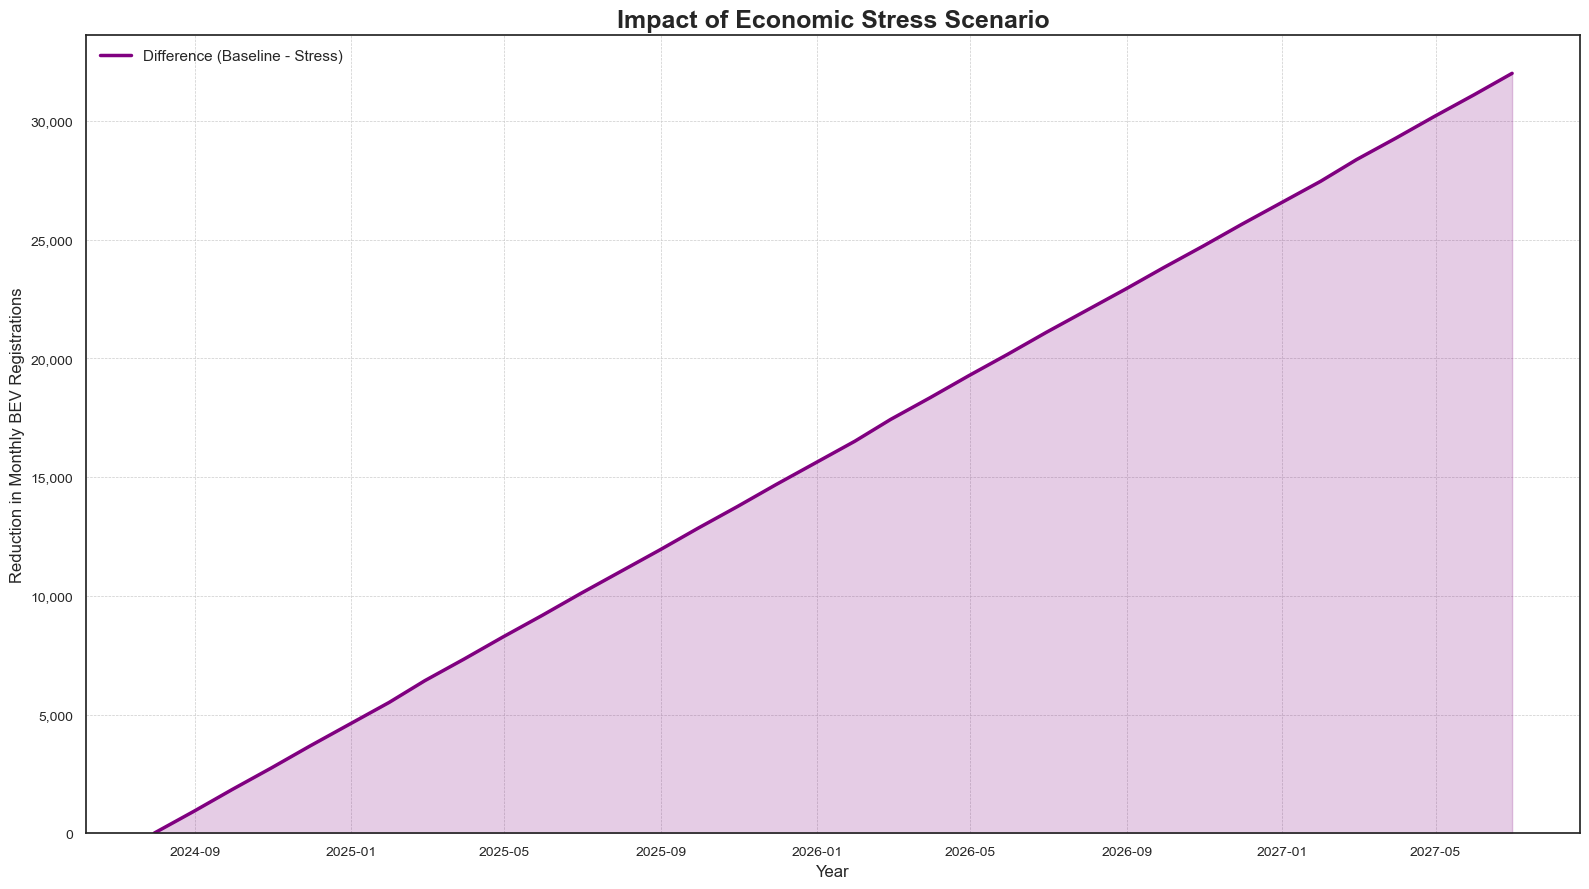

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# (Assuming 'df', 'final_statsmodels_results' from the previous steps are in memory)

# --- 1. Define Future Scenarios (3-Year Horizon) ---
print("--- Defining future scenarios for a 3-year policy-relevant horizon ---")
future_dates = pd.date_range(start='2024-07-01', end='2027-06-01', freq='MS')
n_forecast_periods = len(future_dates)

# Get last known ACTUAL values as starting points for projections
last_rhdi = df['RHDI_per_head'].iloc[-1]
last_infra = df['Charging_Infrastructure'].iloc[-1]
last_gt = df['GT_Index'].iloc[-1]

# --- Project the future path of the ACTUAL variables ---
# Baseline Scenario
obr_rhdi_growth = (1 + 0.005)**(1/12)
required_monthly_rate = round((300000 - last_infra) / len(pd.date_range(start='2024-07-01', end='2030-12-01', freq='MS')))
future_rhdi_baseline = pd.Series(last_rhdi * np.cumprod(np.repeat(obr_rhdi_growth, n_forecast_periods)), index=future_dates)
future_infra_baseline = pd.Series(last_infra + np.cumsum(np.repeat(required_monthly_rate, n_forecast_periods)), index=future_dates)
future_gt_baseline = pd.Series(np.repeat(last_gt, n_forecast_periods), index=future_dates)

# Economic Stress Scenario
stress_path = np.concatenate([np.repeat((1 - 0.02)**(1/12), 24), np.repeat(obr_rhdi_growth, n_forecast_periods - 24)])
future_rhdi_stress = pd.Series(last_rhdi * np.cumprod(stress_path), index=future_dates)
infra_stress_path = np.repeat(required_monthly_rate / 2, n_forecast_periods)
future_infra_stress = pd.Series(last_infra + np.cumsum(infra_stress_path), index=future_dates)

# --- Create the final LAGGED exogenous dataframes for the model ---
infra_full_baseline = pd.concat([df['Charging_Infrastructure'], future_infra_baseline])
infra_full_stress = pd.concat([df['Charging_Infrastructure'], future_infra_stress])
gt_full_series = pd.concat([df['GT_Index'], future_gt_baseline])

future_exog_baseline = pd.DataFrame({
    'RHDI_per_head': future_rhdi_baseline,
    'Charging_Infrastructure_lag_1': infra_full_baseline.shift(1).loc[future_dates],
    'GT_Index_lag_2': gt_full_series.shift(2).loc[future_dates]
})

future_exog_stress = pd.DataFrame({
    'RHDI_per_head': future_rhdi_stress,
    'Charging_Infrastructure_lag_1': infra_full_stress.shift(1).loc[future_dates],
    'GT_Index_lag_2': gt_full_series.shift(2).loc[future_dates]
})
print("Future exogenous variables created correctly.")

# --- 2. Generate Forecasts using .get_forecast() ---
print("\n--- Generating forecasts for scenarios using statsmodels ---")

# Baseline Forecast
forecast_obj_baseline = final_statsmodels_results.get_forecast(steps=n_forecast_periods, exog=future_exog_baseline)
forecast_baseline = forecast_obj_baseline.predicted_mean
conf_int_baseline = forecast_obj_baseline.conf_int(alpha=0.05)

# Economic Stress Forecast
forecast_obj_stress = final_statsmodels_results.get_forecast(steps=n_forecast_periods, exog=future_exog_stress)
forecast_stress = forecast_obj_stress.predicted_mean

# --- 3. Create the Main Forecast Plot ---
print("\n--- Generating main forecast plot ---")
plt.style.use('seaborn-v0_8-ticks')
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(df.index, df['BEV_Registrations'], label='Historical Registrations', color='black', linewidth=2.5)
ax.plot(forecast_baseline.index, forecast_baseline, label='Baseline Forecast', color='#0077b6', linewidth=2)
ax.fill_between(conf_int_baseline.index, conf_int_baseline.iloc[:, 0], conf_int_baseline.iloc[:, 1], color='#0077b6', alpha=0.2, label='Baseline 95% CI')
ax.plot(forecast_stress.index, forecast_stress, label='Economic Stress Forecast', color='#d62828', linestyle='--', linewidth=2)

ax.set_title('Policy-Relevant Forecast: Impact of Scenarios on BEV Registrations (3-Year Horizon)', fontsize=18, weight='bold')
ax.set_ylabel('Monthly BEV Registrations', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylim(0)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('sarimax_3_year_forecast_main_corrected.png', dpi=300)
print("Generated 'sarimax_3_year_forecast_main_corrected.png'")
plt.show()

# --- 4. Create the Impact Analysis (Difference) Plot ---
print("\n--- Generating impact analysis plot (Forecast Difference) ---")
fig_diff, ax_diff = plt.subplots(figsize=(16, 9))

forecast_difference = forecast_baseline - forecast_stress
ax_diff.plot(forecast_difference.index, forecast_difference, label='Difference (Baseline - Stress)', color='purple', linewidth=2.5)
ax_diff.fill_between(forecast_difference.index, 0, forecast_difference, color='purple', alpha=0.2)

ax_diff.set_title('Impact of Economic Stress Scenario', fontsize=18, weight='bold')
ax_diff.set_ylabel('Reduction in Monthly BEV Registrations', fontsize=12)
ax_diff.set_xlabel('Year', fontsize=12)
ax_diff.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax_diff.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_diff.set_ylim(0)
ax_diff.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig('sarimax_forecast_difference_corrected.png', dpi=300)
print("Generated 'sarimax_forecast_difference_corrected.png'")
plt.show()

**Interpretation**
1. Main Forecast Plot (First Image):

- The plot clearly shows that the "Economic Stress Forecast" (red dashed line) results in a consistently lower number of monthly BEV registrations compared to the "Baseline Forecast" (blue solid line).

- Both forecasts follow a realistic path, continuing the strong upward trend and seasonal patterns observed in the historical data. The confidence interval around the baseline provides a reasonable estimate of the forecast's uncertainty.

- Key Takeaway: The visual evidence suggests that while the underlying growth momentum for BEVs is strong, it is not immune to economic conditions. A recessionary shock would noticeably suppress the number of vehicles sold each month.

2. Impact Analysis Plot (Second Image):

- This plot provides a direct and clear quantification of the risk posed by the economic stress scenario. It shows the difference in forecasted registrations between the two scenarios.

- Growing Impact Over Time: The impact of the economic stress is not constant; it grows over time. The plot shows that the gap between the two forecasts widens, starting from zero and increasing to a reduction of over 30,000 registrations per month by the end of the forecast horizon in mid-2027.

- Key Takeaway: This demonstrates that a sustained period of economic weakness would have a cumulative and worsening effect on the BEV market, significantly slowing the UK's progress towards its adoption targets.

### 6.2 Long-Term Strategic Forecast (Logistic Model)

In [114]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import curve_fit


# --- 1. Load Data to Get Timeframe ---
# We need the historical data to establish the start date and length for our time index.
df = pd.read_csv('enhanced_imputed_dataset.csv', index_col=0, parse_dates=True)

# --- 2. Define Logistic Function and Fit to Historical Data ---
def logistic_function(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

historical_share = df['BEV_Share']
time_index = np.arange(len(historical_share))
market_ceiling = 0.98

# Fit the curve to get the baseline parameters
params, _ = curve_fit(
    logistic_function,
    time_index,
    historical_share,
    p0=[market_ceiling, 0.1, 100], # Initial guesses
    bounds=([0.97, 0, 0], [0.99, 1, 200]) # Bounds for parameters
    )
logistic_L, logistic_k, logistic_t0 = params


# --- 3. Define Scenarios ---
scenario_adjustments = {
    'Baseline': 1.0,
    'Economic_Stress': 0.95,
    'Market_Driven': 1.05,
    'Infrastructure_Acceleration': 1.07
}

# --- 4. Calculate "Mandate Compliant" Parameters ---
full_date_range = pd.date_range(start=df.index.min(), end='2035-12-01', freq='MS')
target_80_date = pd.to_datetime('2030-01-01')
t_80 = np.where(full_date_range == target_80_date)[0][0]
target_100_date = pd.to_datetime('2035-01-01')
t_100 = np.where(full_date_range == target_100_date)[0][0]

def error_function(params):
    k, t0 = params
    y_at_t_80 = logistic_function(t_80, market_ceiling, k, t0)
    y_at_t_100 = logistic_function(t_100, market_ceiling, k, t0)
    return (y_at_t_80 - 0.80)**2 + (y_at_t_100 - market_ceiling)**2

result = minimize(error_function, [logistic_k, logistic_t0], method='Nelder-Mead')
mandate_k, mandate_t0 = result.x

# --- 5. Generate Table Data ---
milestones = {
    '50% Adoption': 0.50,
    '80% Adoption': 0.80,
    '100% (98%) Adoption': 0.98
}
milestone_results = {}
full_time_index = np.arange(len(full_date_range))

# Generate data for organic scenarios
for scenario, adjustment in scenario_adjustments.items():
    milestone_results[scenario] = {}
    adjusted_k = logistic_k * adjustment
    scenario_curve = logistic_function(full_time_index, logistic_L, adjusted_k, logistic_t0)
    scenario_series = pd.Series(scenario_curve, index=full_date_range)
    for name, value in milestones.items():
        try:
            date_achieved = scenario_series[scenario_series >= value].index[0]
            milestone_results[scenario][name] = date_achieved.strftime('%b %Y')
        except IndexError:
            milestone_results[scenario][name] = "Not Achieved"

# --- 6. Create and Display the Final Table ---
final_table = pd.DataFrame(milestone_results)

# Reorder columns for better presentation
column_order = [
    'Baseline',
    'Economic_Stress',
    'Market_Driven',
    'Infrastructure_Acceleration',
]
final_table = final_table[column_order]
final_table.index.name = 'Milestone'

print("--- Milestone Achievement Dates by Logistic Scenario ---")
print(final_table)

# Save the table to a CSV file for your report
final_table.to_csv('logistic_milestone_summary.csv')
print("\nTable saved to 'logistic_milestone_summary.csv'")

--- Milestone Achievement Dates by Logistic Scenario ---
                         Baseline Economic_Stress Market_Driven  \
Milestone                                                         
50% Adoption             Jan 2028        Jan 2028      Dec 2027   
80% Adoption             Jan 2032        Apr 2032      Nov 2031   
100% (98%) Adoption  Not Achieved    Not Achieved  Not Achieved   

                    Infrastructure_Acceleration  
Milestone                                        
50% Adoption                           Dec 2027  
80% Adoption                           Oct 2031  
100% (98%) Adoption                Not Achieved  

Table saved to 'logistic_milestone_summary.csv'


In [115]:
final_table

,Baseline,Economic_Stress,Market_Driven,Infrastructure_Acceleration
Milestone,,,,
50% Adoption,Jan 2028,Jan 2028,Dec 2027,Dec 2027
80% Adoption,Jan 2032,Apr 2032,Nov 2031,Oct 2031
100% (98%) Adoption,Not Achieved,Not Achieved,Not Achieved,Not Achieved


Generated 'logistic_scenario_baseline.png'


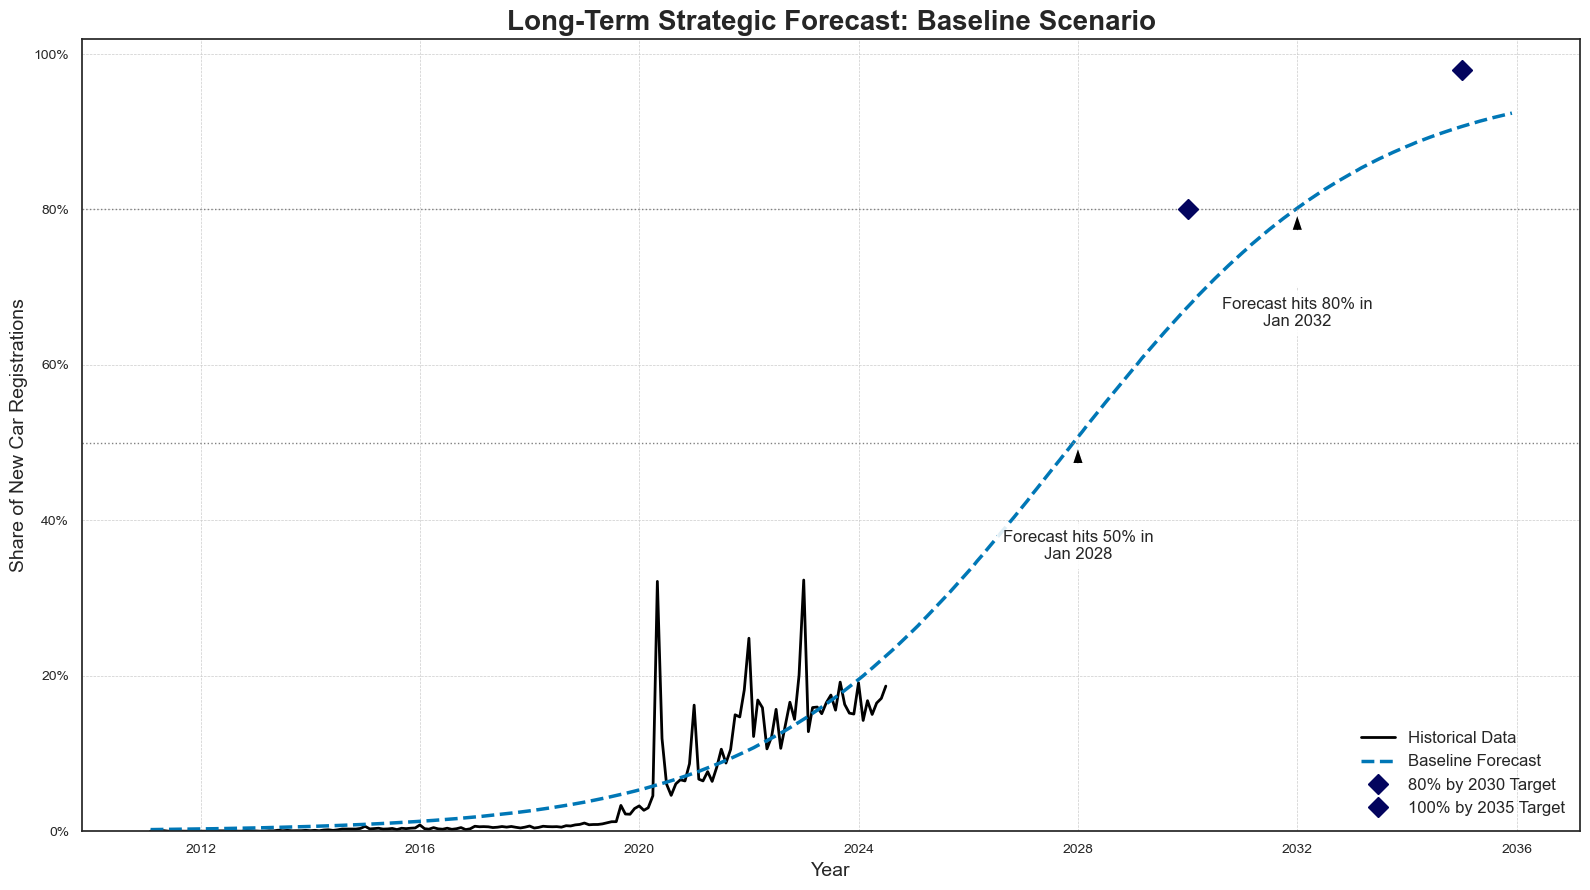

Generated 'logistic_scenario_economic_stress.png'


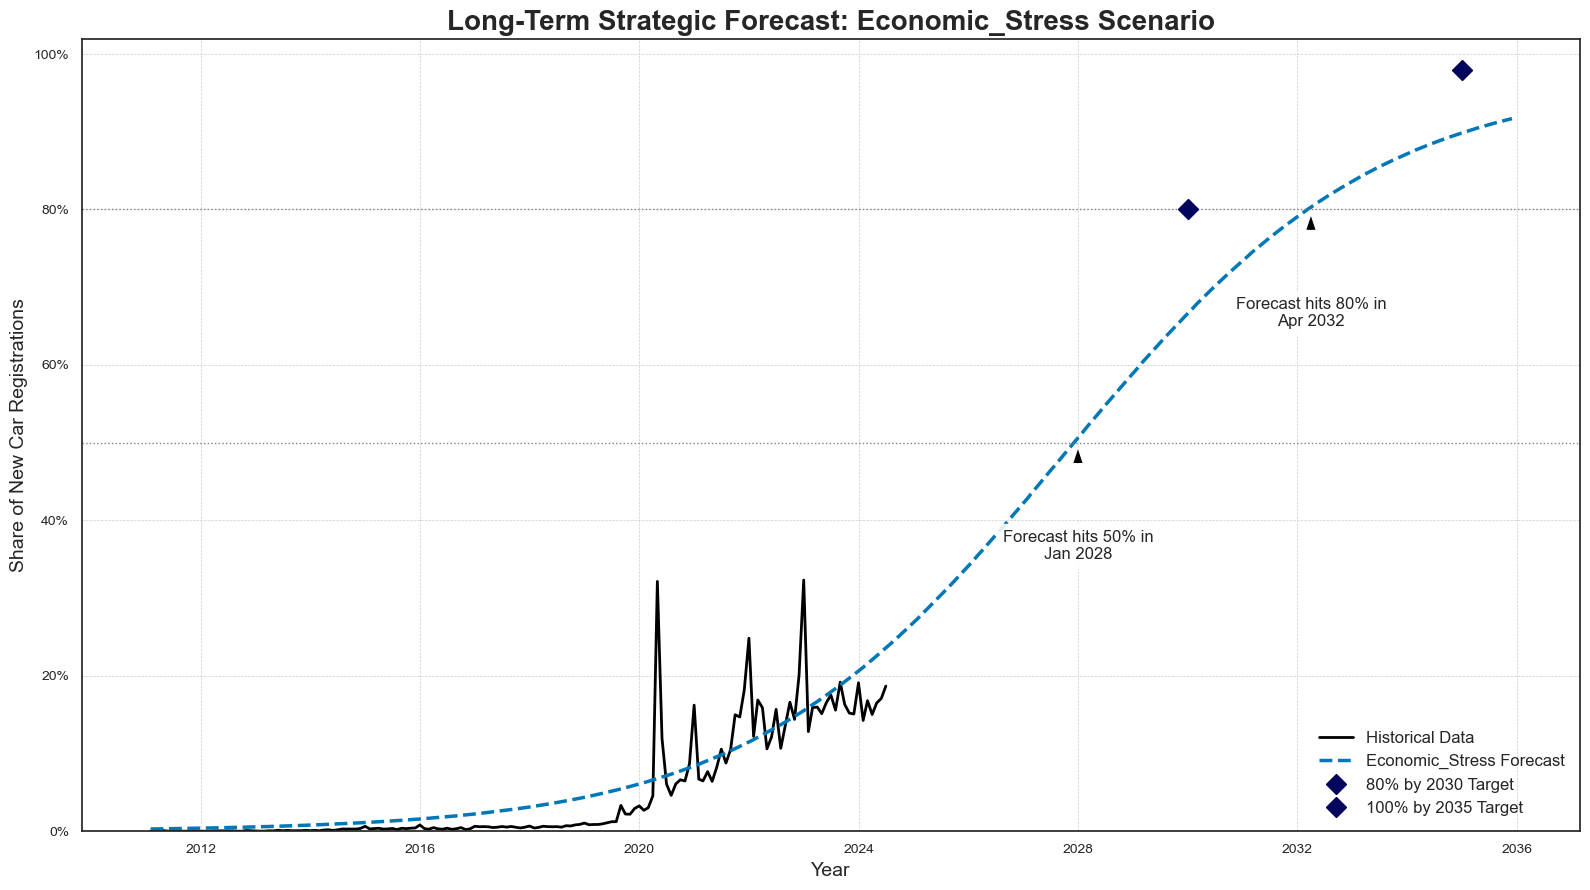

Generated 'logistic_scenario_market_driven.png'


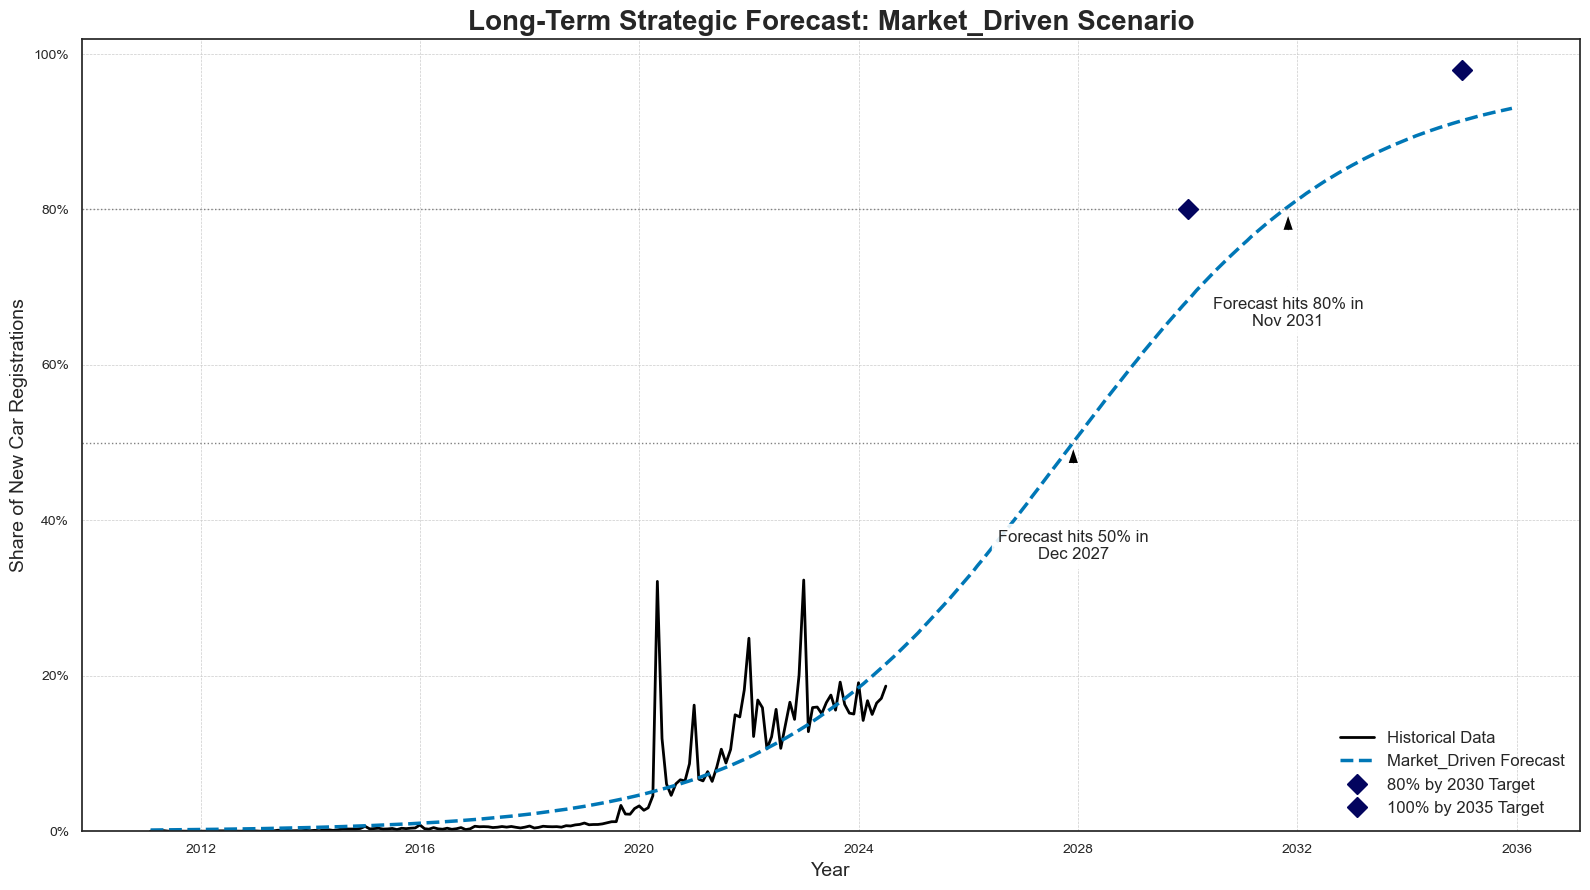

Generated 'logistic_scenario_infrastructure_acceleration.png'


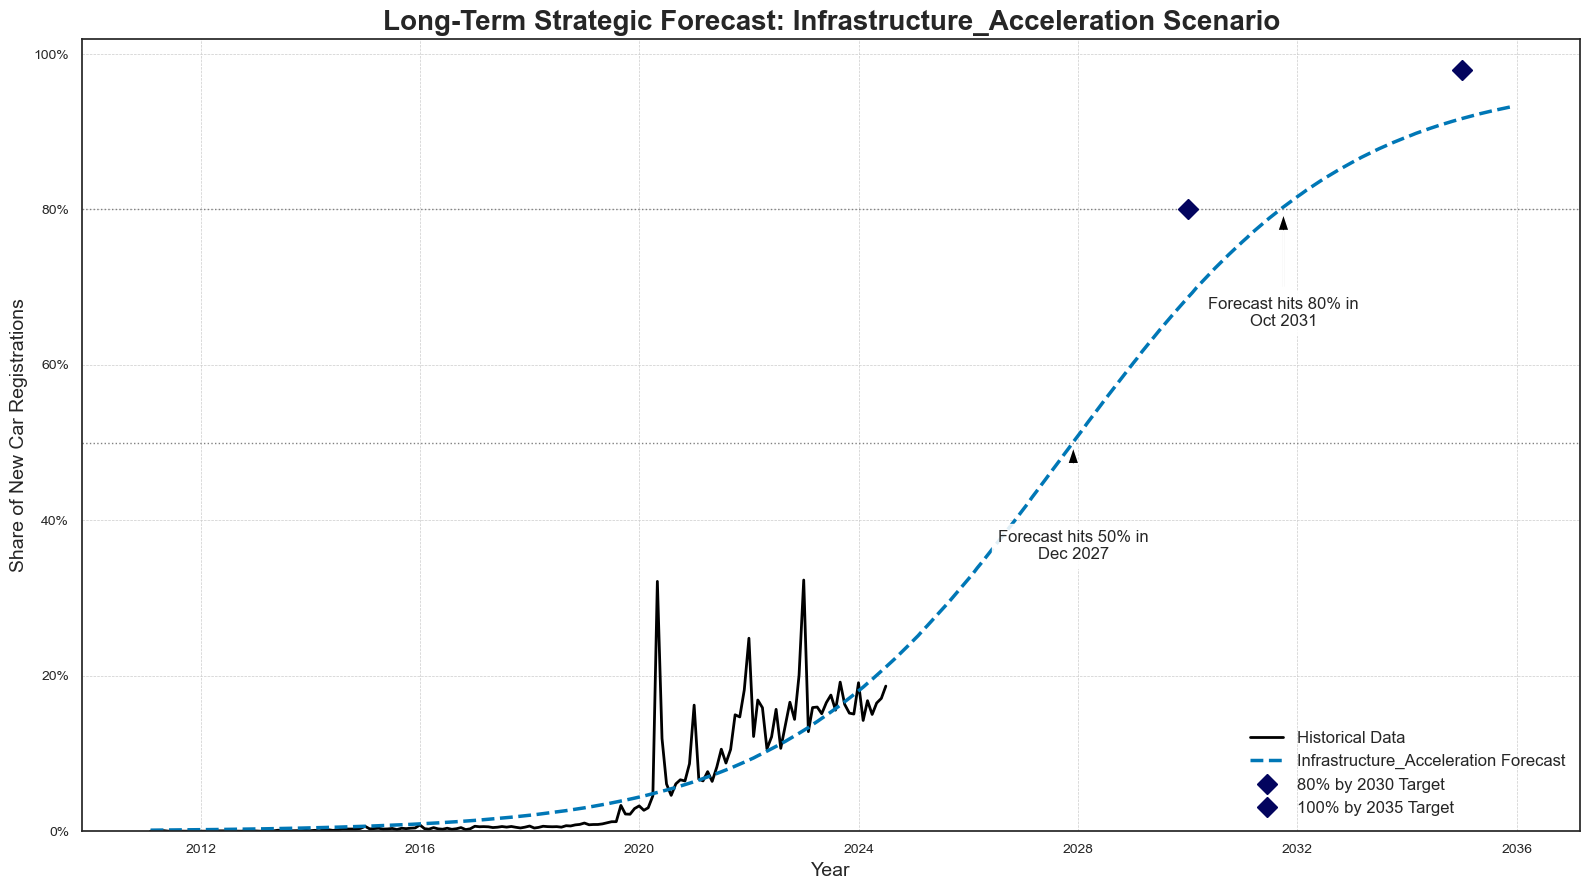

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# (Assuming 'df', and the fitted logistic parameters 'logistic_L', 'logistic_k',
# and 'logistic_t0' from the previous steps are in memory)

# --- 1. Define Scenarios and Plotting Parameters ---
scenario_adjustments = {
    'Baseline': 1.0,
    'Economic_Stress': 0.95,
    'Market_Driven': 1.05,
    'Infrastructure_Acceleration': 1.07
}

# Generate the full date range for plotting
full_date_range = pd.date_range(start=df.index.min(), end='2035-12-01', freq='MS')
full_time_index = np.arange(len(full_date_range))

# --- 2. Iterate Through Scenarios and Create a Plot for Each ---
for scenario, adjustment in scenario_adjustments.items():
    # Adjust the growth parameter 'k' for the current scenario
    adjusted_k = logistic_k * adjustment

    # Generate the logistic curve for this scenario
    scenario_curve = logistic_function(full_time_index, logistic_L, adjusted_k, logistic_t0)
    scenario_series = pd.Series(scenario_curve, index=full_date_range)

    # --- Create the plot ---
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot historical data and the scenario forecast
    ax.plot(df.index, df['BEV_Share'], label='Historical Data', color='black', linewidth=2)
    ax.plot(scenario_series.index, scenario_series,
            label=f'{scenario} Forecast', color='#0077b6', linestyle='--', linewidth=2.5)

    # --- Add Milestone Annotations ---
    milestones_to_plot = {
        '50%': (0.50, 0.35),
        '80%': (0.80, 0.65),
        '98%': (0.98, 0.83)
    }

    for pct_str, (pct_val, text_y_pos) in milestones_to_plot.items():
        try:
            # Find the date the milestone is achieved
            date_achieved = scenario_series[scenario_series >= pct_val].index[0]
            # Add a horizontal line for the milestone
            ax.axhline(y=pct_val, color='grey', linestyle=':', linewidth=1)
            # Add an annotation with the achievement date
            ax.annotate(f'Forecast hits {pct_str} in\n{date_achieved.strftime("%b %Y")}',
                        xy=(date_achieved, pct_val),
                        xytext=(date_achieved, text_y_pos),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                        fontsize=12, ha='center', backgroundcolor='#ffffffE0')
        except IndexError:
            # If the milestone is not achieved, do nothing
            pass

    # --- Add Government Target Markers ---
    ax.plot(pd.to_datetime('2030-01-01'), 0.80, 'D', color='#03045e', markersize=10, label='80% by 2030 Target')
    ax.plot(pd.to_datetime('2035-01-01'), 0.98, 'D', color='#03045e', markersize=10, label='100% by 2035 Target')

    # --- Formatting ---
    ax.set_title(f'Long-Term Strategic Forecast: {scenario} Scenario', fontsize=20, weight='bold')
    ax.set_ylabel('Share of New Car Registrations', fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax.set_ylim(0, 1.02)
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f'logistic_scenario_{scenario.lower()}.png', dpi=300)
    print(f"Generated 'logistic_scenario_{scenario.lower()}.png'")
    plt.show()